In [46]:
import pandas as pd
from datetime import datetime

In [47]:
!pip install kaleido

Defaulting to user installation because normal site-packages is not writeable


In [48]:
simpsons_episodes = pd.read_pickle("./data/simpsons_processed.pkl")

In [49]:
simpsons_episodes.head()

,season,episode,title,airdate,rating,total_votes,desc,director,writer,prod_code,viewers,ep_overall,As_Themselves,Character_Played,Homer_main,Marge_main,Bart_main,Lisa_main,Maggie_main,Treehouse
0,1,1,Simpsons Roasting on an Open Fire,1989-12-17,8.1,8400,Homer is forced to become a department store S...,[David Silverman],[Mimi Pond],7G08,26.7,1,0,0,1,1,1,0,0,0
1,1,2,Bart the Genius,1990-01-14,7.6,5700,Bart ends up at a school for gifted children a...,[David Silverman],[Jon Vitti],7G02,24.5,2,0,0,0,0,1,0,0,0
2,1,3,Homer's Odyssey,1990-01-21,7.3,5000,"After losing his job, Homer contemplates endin...",[Wes Archer],"[Jay Kogen, Wallace Wolodarsky]",7G03,27.5,3,0,1,1,0,0,0,0,0
3,1,4,There's No Disgrace Like Home,1990-01-28,7.6,4900,After being embarrassed by the rest of the fam...,"[Kent Butterworth, Gregg Vanzo]","[Al Jean, Mike Reiss]",7G04,20.2,4,0,0,1,0,0,0,0,0
4,1,5,Bart the General,1990-02-04,7.9,5300,After being beaten up by Nelson Muntz one too ...,[David Silverman],[John Swartzwelder],7G05,27.1,5,0,0,0,0,1,0,0,0


Data dictionary
- **season**: Season that the episode appears in.
- **episode**: Episode number within the respective season.
- **title**: Title of the episode (according to IMDb).
- **airdate**: Original airdate of the episode (in the US).
- **rating**: Average rating (out of 10) given to the episode by users of IMDb.
- **total_votes**: Total number of ratings on IMDb used to calculate the average rating.
- **desc**: The provided synopsis given for the episode.
- **director**: The director (or directors) for the episode; is in list format.
- **writer**: The writer (or writers) of the episode; is in list format.
- **prod_code**: The production code used for the episode.
- **viewers**: The number of viewers (of original US airing) of the episode in millions.
- **ep_overall**: The overall episode number (so episode number factoring in all previous seasons).
- **As_Themselves**: A flag which indicates whether any celebrity guest stars appeared in episode (credited as Himself/Herself/Themselves/Narrator).
- **Character_Played**: A flag which indicates whether any celebrity guest stars appeared in episode (as a named character).
- **Homer_main**: Homer was mentioned in either the episode title or description (and so is considered a main/featured character for analysis purposes).
- **Marge_main**: Marge was mentioned in either the episode title or description (and so is considered a main/featured character for analysis purposes).
- **Bart_main**: Bart was mentioned in either the episode title or description (and so is considered a main/featured character for analysis purposes).
- **Lisa_main**: Lisa was mentioned in either the episode title or description (and so is considered a main/featured character for analysis purposes).
- **Maggie_main**: Maggie was mentioned in either the episode title or description (and so is considered a main/featured character for analysis purposes).
- **Treehouse**: This is a `Treehouse of Horror` episode.

In [50]:
print(f"Highest rated episode has a score of {simpsons_episodes.rating.max()}")
print(f"Lowest rated episode has a score of {simpsons_episodes.rating.min()}")

Highest rated episode has a score of 9.3
Lowest rated episode has a score of 4.0


# Split scores up between
- Above 8.5
- Above 7.5
- Above 6.5
- Above 5.5
- Less than 5.5

In [51]:
def convert_rating(rating):
    if rating >= 8.5:
        output = 1
    elif rating >= 7.5:
        output = 2
    elif rating >= 6.5:
        output = 3
    elif rating >= 5.5:
        output = 4
    else:
        output = 5
    
    return output

In [68]:
simpsons_episodes.rating = simpsons_episodes.rating.astype('float')
simpsons_episodes.viewers = simpsons_episodes.viewers.astype('float')

In [53]:
simpsons_episodes['rating_group'] = simpsons_episodes.rating.apply(convert_rating)
simpsons_episodes['votes_k'] = simpsons_episodes.total_votes.apply(lambda x: x/1000)
simpsons_episodes['title'] = simpsons_episodes.title.apply(lambda x: x.strip())
simpsons_episodes['date_format'] = simpsons_episodes.airdate.apply(lambda x: x.strftime("%a %d %b %Y"))

# Other summaries?

Writers:

- How many episodes is each person credited to?
- What was the average rating of a writers episodes?
- Who did a writer mainly focus on (e.g. which member of the simpsons family features most often in their episodes?)
    - In particular, look out for any writer who has a much higher percentage for a specific character (instead of just... writer X wrote one more episode about Bart etc.)

Treehouse of Horror:
- Any particular writers or directors that work on these episodes a lot?
- How do these episodes compare rating/viewers wise to the rest of the season (or the season average)

Guest Stars:
- Does adding a guest star generally improve the ratings/viewership of an episode?

# BERTopic

Using the episode title and description, what topics does BERTopic produce?
- Plot these topics in 3D for visualization
- What do these topics generally represent?
- What are the average ratings/viewerships of these topics?

# Episode Rating Breakdown

In [54]:
import plotly.graph_objects as go
import numpy as np

In [55]:
# There is an episode (S28E12&13) that is actually a two parter. Therefore, duplicate the details (but add part 1 and 2 to title)

mask1 = (simpsons_episodes.season==28)
mask2 = (simpsons_episodes.episode==12)
two_parter = simpsons_episodes[mask1 & mask2].copy()
simpsons_episodes['title'] = np.where(mask1 & mask2, "The Great Phatsby (part 1)", simpsons_episodes['title'])
two_parter.title = "The Great Phatsby (part 2)"
two_parter.episode = 13
simpsons_episodes_full = pd.concat([simpsons_episodes, two_parter])
simpsons_episodes_full.reset_index(drop=True, inplace=True)

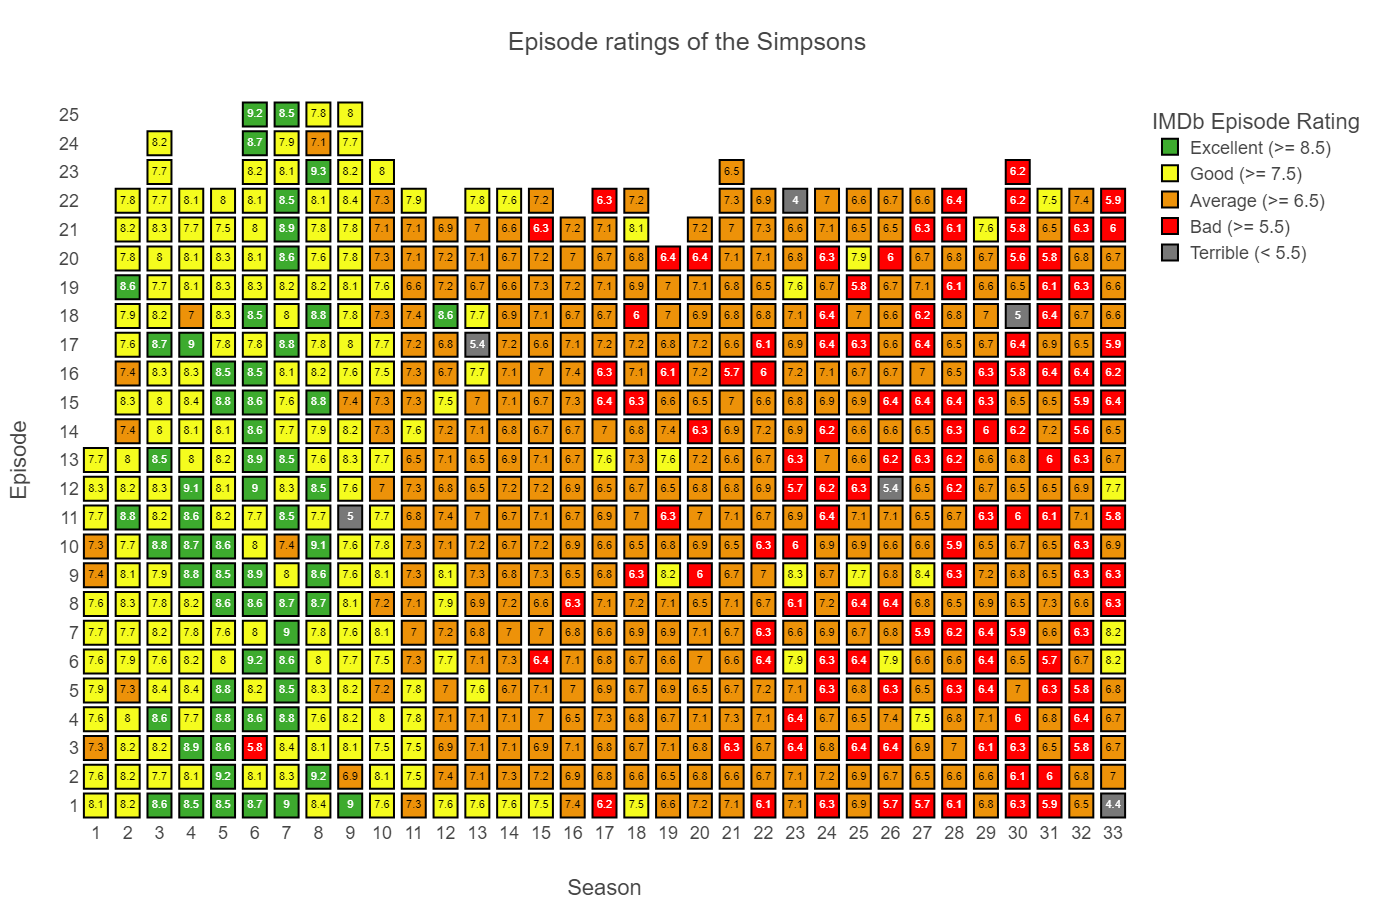

In [56]:
fig = go.Figure()

rating_groups = ['Excellent (>= 8.5)', 'Good (>= 7.5)', 'Average (>= 6.5)', 'Bad (>= 5.5)', 'Terrible (< 5.5)']
rating_color = ['rgb(61, 171, 46)', 'rgb(245, 252, 30)', 'rgb(237, 146, 9)', 'rgb(255, 0, 0)', 'rgb(120, 120, 120)']
text_color = ['white', 'black', 'black', 'white', 'white']

config = {'displayModeBar': False}

for i in range(1,6):
    selection = simpsons_episodes_full[simpsons_episodes_full.rating_group == i]
    
    fig.add_trace(
        go.Scatter(
            x=selection.season, y=selection.episode,
            name=rating_groups[i-1],
            mode='markers+text',
            text=selection.rating,
            textposition='middle center',
            textfont = dict(
                family = "arial",
                color=text_color[i-1],
                size = 11
            ),
            marker_color=rating_color[i-1],
            customdata = selection[['season', 'episode', 'title', 'rating', 'date_format', 'votes_k']],
            hovertemplate="<br>".join([
                "<b>%{customdata[2]}</b><br>",
                "<b>Season %{customdata[0]} - Episode %{customdata[1]}</b>",
                "<b>Original Airdate:</b> %{customdata[4]}",
                "<b>IMDb Rating: %{customdata[3]:.1f}</b> (%{customdata[5]:.1f}k votes)",
                "<extra></extra>",
            ]),
    ))
    
fig.update_layout(
    font_family="Arial",
    font_size=18,
    title="Episode ratings of the Simpsons",
    width=1300,
    height=900,
    showlegend=True,
    xaxis_title="Season",
    yaxis_title="Episode",
    template="none",#"simple_white",
    legend_title_text='IMDb Episode Rating'
)

fig.update_traces(
    marker=dict(size=24, symbol="square", line=dict(width=2, color="Black")),
    selector=dict(mode="markers+text"),
)

fig.update_xaxes(range=[0.5, 33.5], tick0=1, dtick=1, showgrid=False, fixedrange=True)
fig.update_yaxes(range=[0.5, 25.5], tick0=1, dtick=1, showgrid=False, fixedrange=True)

    
fig.show(config=config)

In [57]:
fig.write_html("./img/simpsons_episode_rating.html", include_plotlyjs='cdn')

In [58]:
fig.write_image("./img/simpsons_episode_rating.png")

# Season Summaries

- How many episodes features each family member as the 'main'?
- What was the average rating of each season?
- What was the average viewership of each season?
- How many of each type of guest star feature in each season?
- How many total guest stars appear in a season?
- What was the highest rated episode each season? Any commonality between them?

- Any correlation between the above figures?

In [97]:
simpsons_episodes['guest'] = simpsons_episodes.As_Themselves + simpsons_episodes.Character_Played
agg_functions = {'season': 'first', 'rating': 'mean', 'viewers': 'mean',
                 'As_Themselves': 'sum', 'Character_Played': 'sum', 'guest': 'mean',
                 'Homer_main': 'sum', 'Marge_main': 'sum', 'Bart_main': 'sum',
                 'Lisa_main': 'sum', 'Maggie_main': 'sum'}
simpsons_season = simpsons_episodes.groupby(simpsons_episodes['season']).aggregate(agg_functions)

simpsons_season.rating = simpsons_season.rating.round(2)
simpsons_season.viewers = simpsons_season.viewers.round(2)
simpsons_season['guest_count'] = simpsons_season.As_Themselves + simpsons_season.Character_Played

In [98]:
simpsons_season.head()

,season,rating,viewers,As_Themselves,Character_Played,guest,Homer_main,Marge_main,Bart_main,Lisa_main,Maggie_main,guest_count
season,,,,,,,,,,,,
1,1,7.68,27.81,0,6,0.461538,7,4,6,2,0,6
2,2,7.98,24.40,5,13,0.818182,15,3,10,4,1,18
3,3,8.15,21.77,16,8,1.000000,17,4,12,6,1,24
4,4,8.26,22.40,17,6,1.045455,16,8,12,10,2,23
5,5,8.33,18.91,12,6,0.818182,12,4,10,1,1,18


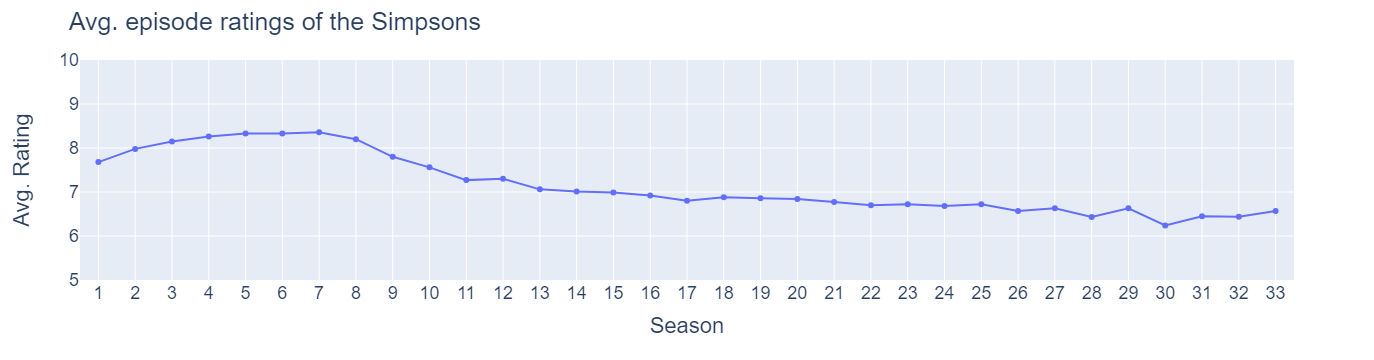

In [116]:
import plotly.express as px
fig = px.line(simpsons_season, x='season', y='rating', markers=True)
fig.update_yaxes(range=[5, 10])

fig.update_layout(
    font_family="Arial",
    font_size=18,
    title="Avg. episode ratings of the Simpsons",
    xaxis_title="Season",
    yaxis_title="Avg. Rating",
)

fig.update_xaxes(range=[0.5, 33.5], tick0=1, dtick=1, showgrid=True, fixedrange=False)

fig.show()

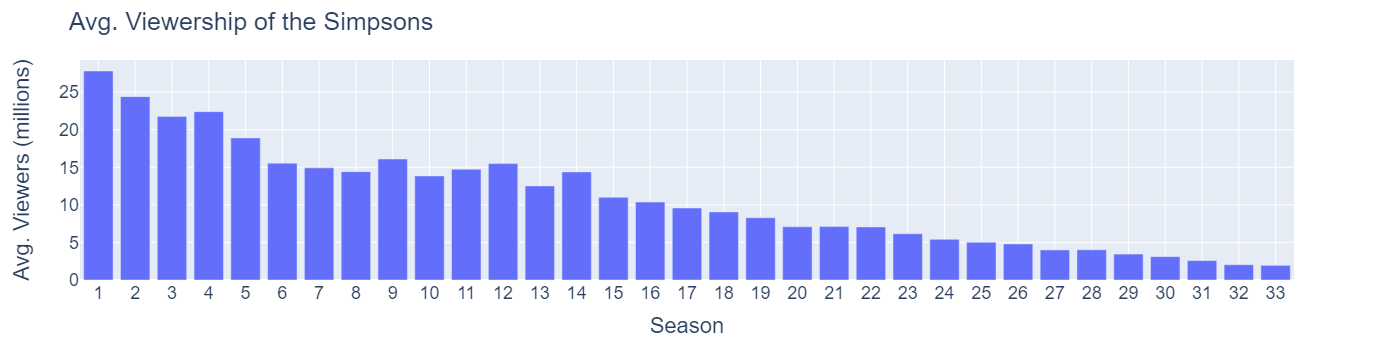

In [115]:
fig = px.bar(simpsons_season, x='season', y='viewers')

fig.update_layout(
    font_family="Arial",
    font_size=18,
    title="Avg. Viewership of the Simpsons",
    xaxis_title="Season",
    yaxis_title="Avg. Viewers (millions)"
)
fig.update_xaxes(range=[0.5, 33.5], tick0=1, dtick=1, showgrid=True)

fig.show()

In [ ]:
# Plot the viewership for the treehouse of horror episode again the sea

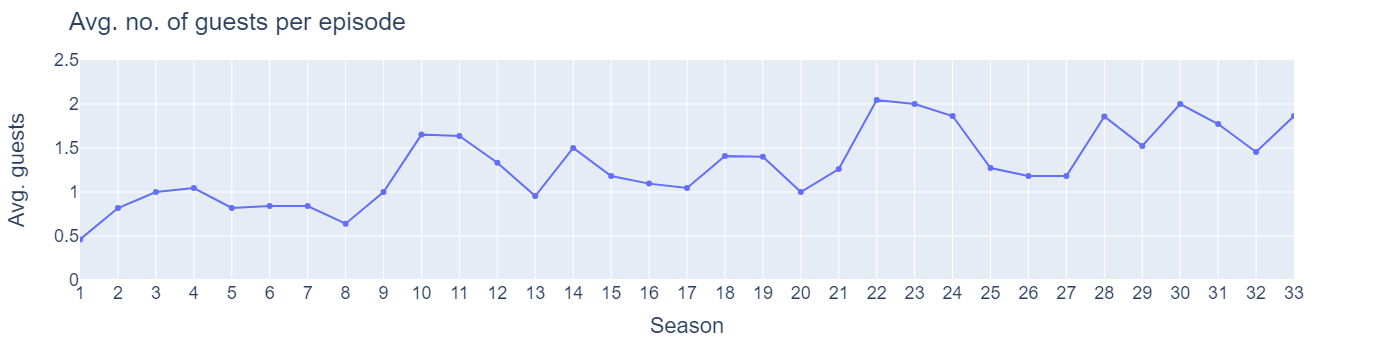

In [131]:
fig = px.line(simpsons_season, x='season', y='guest', markers=True)

fig.update_layout(
    font_family="Arial",
    font_size=18,
    title="Avg. no. of guests per episode",
    xaxis_title="Season",
    yaxis_title="Avg. guests"
)
fig.update_xaxes(range=[1, 33], tick0=1, dtick=1)
fig.update_yaxes(range=[0, 2.5])

fig.show()

In [ ]:
# Bar chart of no. of episodes with a guest against episodes without
# Then go on to shown average rating/viewership for guest episodes (and non-guest)

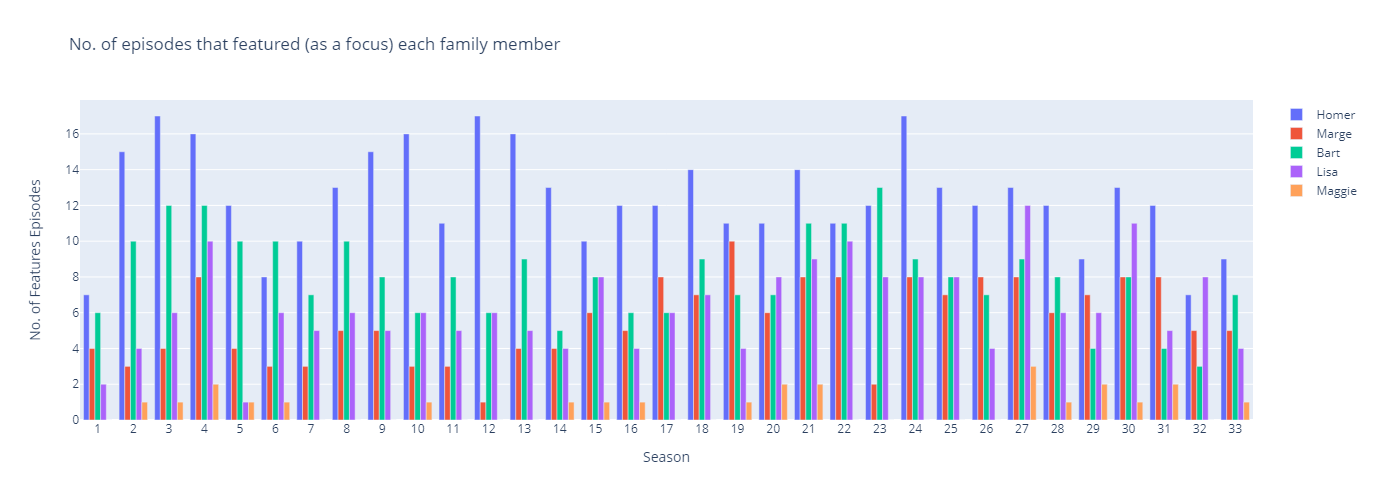

In [133]:
import plotly.graph_objects as go

fig = go.Figure(data=[
    go.Bar(name='Homer', x=simpsons_season.season, y=simpsons_season.Homer_main),
    go.Bar(name='Marge', x=simpsons_season.season, y=simpsons_season.Marge_main),
    go.Bar(name='Bart', x=simpsons_season.season, y=simpsons_season.Bart_main),
    go.Bar(name='Lisa', x=simpsons_season.season, y=simpsons_season.Lisa_main),
    go.Bar(name='Maggie', x=simpsons_season.season, y=simpsons_season.Maggie_main),
])
# Change the bar mode
#fig.update_layout(barmode='stack')
fig.update_xaxes(range=[0.5, 33.5], tick0=1, dtick=1)
fig.update_layout(
    width=1300,
    height=500,
    xaxis_title='Season',
    yaxis_title='No. of Features Episodes',
    title='No. of episodes that featured (as a focus) each family member'
)
fig.show()